In [1]:
import cupy as cp

In [2]:
class sRNN:

    """
    sRNN 神经网络
    """
    
    def __init__(self, input_size: int = None, hidden_size: int = None, output_size: int = None):

        """
        初始化 sRNN 网络的权重矩阵和偏置向量

        Paramters
        ---------
        input_size : 输入维度
        hidden_size : 隐层状态维度
        output_size : 输出维度
        batch_first : 输入张量的第一个维度是 batch_size 时，该变量设置为 True，否则为 False
        """
        
        # U: 形状为 [hidden_size, hidden_size]
        self.U = cp.random.normal(0, 1, (hidden_size, hidden_size))
        # W: 形状为 [hidden_size, input_size]
        self.W = cp.random.normal(0, 1, (hidden_size, input_size))
        # b: 形状为 hidden_size
        self.b = cp.random.normal(0, 1, hidden_size)
        # V: 形状为 [output_size, hidden_size]
        self.V = cp.random.normal(0, 1, (output_size, hidden_size))
        # c: 形状为 output_size
        self.c = cp.random.normal(0, 1, output_size)

        self.hidden_size = hidden_size

    @ staticmethod
    def tanh(z: cp.ndarray = None) -> cp.ndarray:

        """
        tanh 激活函数

        Parameters
        ----------
        z : 净输入
        
        Returns
        -------
        y : 激活值
        """
        
        y = (cp.exp(z) - cp.exp( - z)) / (cp.exp(z) + cp.exp( - z))
        
        return y

    @ staticmethod
    def softmax(z, dim: int = 1) -> cp.ndarray:
        
        """
        softmax 函数

        Parameters
        ----------
        z : 净输入
        
        Returns
        -------
        y : 激活值
        """
        
        y = cp.exp(z) / cp.expand_dims(cp.sum(cp.exp(z), axis = dim), axis = -1)
        
        return y

    # 单个 sRNN 单元
    def RNN_cell(self, x: cp.ndarray = None, h: cp.ndarray = None) -> tuple[cp.ndarray, cp.ndarray]:

        """
        RNN 单元，将 t 时刻的输入 x 和 t-1 时刻的隐层状态输出 h 转换为 t 时刻的预测值 y_hat 和隐层状态输出 h

        Paramters
        ---------
        x : 输入张量，形状为 [batch_size, 1, input_size]
        h : 前一时刻的隐层状态，形状为 [batch_size, 1, input_size]

        Returns
        -------
        y_hat : RNN 单元当前时刻的预测值，形状为 [batch_size, 1, output_size]
        h : 当前时刻的隐层状态输出，形状为 [batch_size, 1, hidden_size]
        """
        
        # s 代表当前时刻的隐层净输入，形状为: [batch_size, hidden_size]
        s = cp.sum(self.U * h, axis = -1) + cp.sum(self.W * x, axis = -1) + self.b
        # 扩展隐层净输入 s 的维度，形状为 [batch_size, 1, hidden_size]
        s = cp.expand_dims(s, axis = 1)
        # 利用 tanh 函数将净输入转换为当前时刻的隐层状态输出 h，形状为 [batch_size, 1, hidden_size]
        h = self.tanh(s)
        # 单个 RNN 单元在当前时刻的净输出 z，形状为 [batch_size, output_size]
        z = cp.sum(self.V * h, axis = -1) + self.c
        # 扩展净输出 z 的维度，形状为 [batch_size, 1, output_size]
        z = cp.expand_dims(z, axis = 1)
        # 单个 RNN 单元在当前时刻的输出 y，形状为 [batch_size, 1, output_size]
        y_hat = self.softmax(z, dim = 2)
        # 修改 y 的形状为 [1, batch_size, output_size]
        y_hat = cp.expand_dims(y_hat.squeeze(1), axis = 0)
        
        return y_hat, h

    # 简单循环神经网络的前向传播算法
    def forward(self, x: cp.ndarray = None) -> tuple[cp.ndarray, cp.ndarray]:

        """
        循环运行单个 RNN 单元，不断利用历史隐层状态输出 h 和当前时刻输入 x 得到当前时刻输出 y

        Paramters
        ---------
        x : 输入张量，形状为 [time_step, batch_size, input_size]

        Returns
        -------
        total_y_hat : 全部时刻的预测输出 y，形状为 [time_step, batch_size, output_size]
        total_h : 最后时刻的隐层状态输出，形状为 [time_step, batch_size, hidden_size]
        """
        
        # 扩充输入张量 x 的维度，形状为 [time_step, batch_size, 1, input_size]
        x = cp.expand_dims(x, axis = 2)

        total_y_hat = []
        total_h = []
        
        # 初始化初始时刻 RNN 单元接收的隐层状态输出为全 0 向量
        h = cp.zeros(self.hidden_size)
        
        # 循环 time_step 次 RNN 单元，得到各个时刻的输出
        for i in range(x.shape[0]):
            y_hat, h = self.RNN_cell(x[i], h = h)
            total_y_hat.append(y_hat)
            total_h.append(h)
        
        # 合并全部时刻的预测输出 y，形状为 [time_step, batch_size, output_size]
        total_y_hat = cp.vstack(total_y_hat)
        # 合并全部时刻的隐状态输出 h，形状为 [time_step, batch_size, hidden_size]
        total_h = cp.vstack(total_h)

        return total_y_hat, total_h
    
    # 反向传播算法更新 RNN 参数
    def backward(self, x: cp.ndarray = None, y = cp.ndarray, lr: float = 0.001):

        """
        反向传播更新 RNN 参数

        Paramters
        ---------
        x : 输入张量，形状为 [time_step, batch_size, input_size]
        y : 真实标签，形状为 [time_step, batch_size, output_size]
        """

        # 利用前向传播算法得到全部时刻的预测输出 y，形状为 [time_step, batch_size, output_size]
        y_hat, h = self.forward(x)
        # 计算参数矩阵 V 的梯度，形状为 [output_size, hidden_size]
        ## cp.expand_dims(y_hat - y, axis = -1) 形状为 [time_step, batch_size, output_size, 1]
        ## cp.expand_dims(h, axis = 2) 形状为 [time_step, batch_size, 1, hidden_size]
        ## (cp.expand_dims(y_hat - y, axis = -1) @ cp.expand_dims(h, axis = 2)) 形状为 [time_step, batch_size, output_size, hidden_size]
        ## cp.sum((cp.expand_dims(y_hat - y, axis = -1) @ cp.expand_dims(h, axis = 2)), axis = 0) 形状为 [batch_size, output_size, hidden_size]
        V_grad = cp.mean(cp.sum((cp.expand_dims(y_hat - y, axis = -1) @ cp.expand_dims(h, axis = 2)), axis = 0), axis = 0)

        # Loss 对最后时刻的 s 求梯度，形状为 [batch_size, hidden_size]
        ## self.V.T 形状为 [hidden_size, output_size]
        ## y_hat[-1] - y[-1] 形状为 [batch_size, output_size]
        ## cp.expand_dims((y_hat[-1] - y[-1]), axis = 1) 形状为 [batch_size, 1, output_size]
        ## self.V.T * cp.expand_dims((y_hat[-1] - y[-1]), axis = 1) 形状为 [batch_size, hidden_size, output_size]
        ## cp.sum(self.V.T * cp.expand_dims((y_hat[:, -1] - y[:, -1]), axis = 1), axis = -1) 形状为 [batch_size, hidden_size]
        ## 1 - h[-1] * h[-1] 形状为 [batch_size, hidden_size]
        L_s = cp.sum(self.V.T * cp.expand_dims((y_hat[-1] - y[-1]), axis = 1), axis = -1) * (1 - h[-1] * h[-1])
        # 计算偏置向量 b 最后时刻的梯度，形状为 [batch_size, hidden_size]
        b_grad = L_s
        # 扩充 L_s 的维度，形状为 [batch_size, hidden_size, 1]
        L_s = cp.expand_dims(L_s, axis = -1)
        # 计算参数矩阵 U 最后时刻的梯度，形状为 [batch_size, hidden_size, hidden_size]
        ## cp.expand_dims(h[-2], axis = 1) 形状为 [batch_size, 1, hidden_size]
        U_grad = L_s @ cp.expand_dims(h[-2], axis = 1)
        # 计算参数矩阵 W 最后时刻的梯度，形状为 [batch_size, hidden_size, input_size]
        ## cp.expand_dims(x[-1], axis = 1) 形状为 [batch_size, 1, input_size]
        W_grad = L_s @ cp.expand_dims(x[-1], axis = 1)
        
        # 反向传播累计各个时刻的梯度，注意初始时刻接受的隐状态输入 h 为全 0 向量，不会影响梯度，可以直接忽略
        for t in range(x.shape[0] - 2, 0, -1):

            # Loss 对当前时刻的 s 求梯度，形状为 [batch_size, hidden_size]
            ## self.U.T 形状为 [hidden_size, hidden_size]
            ## self.U.T @ L_s 形状为 [batch_size, hidden_size, 1]
            ## (self.U.T @ L_s).squeeze(-1) 形状为 [batch_size, hidden_size]
            ## self.V.T 形状为 [hidden_size, output_size]
            ## cp.expand_dims((y_hat[t] - y[t]), axis = 1) 形状为 [batch_size, 1, output_size]
            ## self.V.T * cp.expand_dims(y_hat[t] - y[t], axis = 1) 形状为 [batch_size, hidden_size, output_size]
            ## cp.sum(self.V.T * cp.expand_dims(y_hat[t] - y[t], axis = 1), axis = - 1) 形状为 [batch_size, hidden_size]
            ## ((self.U.T @ L_s).squeeze(-1) + cp.sum(self.V.T * cp.expand_dims(y_hat[t] - y[t], axis = 1), axis = - 1)) 形状为 [batch_size, hidden_size]
            ## 1 - h[-1] * h[-1] 形状为 [batch_size, hidden_size]
            L_s = ((self.U.T @ L_s).squeeze(-1) + cp.sum(self.V.T * cp.expand_dims(y_hat[t] - y[t], axis = 1), axis = - 1)) * (1 - h[t] * h[t])
            # 计算偏置向量 b 当前时刻的梯度，形状为 [batch_size, hidden_size]
            b_grad += L_s
            # 扩充 L_s 的维度，形状为 [batch_size, hidden_size, 1]
            L_s = cp.expand_dims(L_s, axis = -1)
            # 计算参数矩阵 U 当前时刻的梯度，形状为 [batch_size, hidden_size, hidden_size]
            ## cp.expand_dims(h[t - 1], axis = 1) 形状为 [batch_size, 1, hidden_size]
            U_grad += L_s @ cp.expand_dims(h[t - 1], axis = 1)
            # 计算参数矩阵 W 当前时刻的梯度，形状为 [batch_size, hidden_size, input_size]
            ## cp.expand_dims(x[t], axis = 1) 形状为 [batch_size, 1, input_size]
            W_grad += L_s @ cp.expand_dims(x[t], axis = 1)
            
        # 求全部样本的梯度平均值
        U_grad = cp.mean(U_grad, axis = 0) # 形状为 [hidden_size, hidden_size]
        W_grad = cp.mean(W_grad, axis = 0) # 形状为 [hidden_size, input_size]
        b_grad = cp.mean(b_grad, axis = 0) # 形状为 hidden_size

        # 计算偏置向量 c 的梯度，形状为 output_size
        ## cp.sum(y_hat - y, axis = 1) 形状为 [batch_size, output_size]
        c_grad = cp.mean(cp.sum(y_hat - y, axis = 0), axis = 0)
        
        # 利用梯度下降法更新参数
        self.V -= lr * V_grad
        self.U -= lr * U_grad
        self.W -= lr * W_grad
        self.b -= lr * b_grad
        self.c -= lr * c_grad

In [3]:
sen = """我向你奔赴而来，你就是星辰大海。"""

In [4]:
import jieba
vocabs = [vocab for vocab in jieba.cut(sen)]
vocabs = ["<begin>", "《星辰大海》", "歌手：黄霄云"] + vocabs + ["<end>"]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LIANGX~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.376 seconds.
Prefix dict has been built successfully.


In [5]:
import numpy as np
word = np.unique(vocabs)
word_dict = {}
vocab_dict = {}
for i in range(len(word)):
    emb = [0] * len(word)
    emb[i] = 1
    word_dict[word[i]] = emb
    vocab_dict[i] = word[i]
input_size = len(word)
hidden_size = 10
output_size = len(word)
X = cp.array([[word_dict[vocab]] for vocab in vocabs[:-1]])
y = cp.array([[word_dict[vocab]] for vocab in vocabs[1:]])

In [ ]:
# 实例化 sRNN 循环神经网络
rnn = sRNN(input_size, hidden_size, output_size)

In [7]:
# 定义评估函数
def eval(y: cp.ndarray = None, y_hat: cp.ndarray = None) -> cp.ndarray:
        
    """
    评估模型表现

    Parameters
    ----------
    y : 真实标签
    y_hat : 预测标签

    Returns
    -------
    loss : 交叉熵损失值
    """
    
    # loss 为标量，将单个样本每个类别、每个时刻的损失累加在一起得到单个样本的交叉熵损失，最后对所有样本的损失求平均
    ## y * cp.log(y_hat) 形状为 [time_step, batch_size, output_size]
    ## cp.sum(y * cp.log(y_hat), axis = -1) 形状为 [time_step, batch_size]
    ## cp.sum(cp.sum(y * cp.log(y_hat), axis = -1), axis = 0) 形状为 batch_size
    loss = - cp.sum(cp.sum(y * cp.log(y_hat), axis = -1), axis = 0)
    loss = cp.mean(loss).item()

    return loss

In [8]:
train_loss = []
# 训练 100 次
for i in range(100):
    
    # 反向传播更新参数
    rnn.backward(X, y, lr = 0.01)
    # 前向传播评估算法表现
    y_hat, h = rnn.forward(X)
    # 评估本次更新参数后的算法表现
    loss = eval(y, y_hat)
    print(loss)
    train_loss.append(loss)

61.378543606781555
71.27756893628316
65.94723844970841
55.17210338190053
50.89486410637682
57.04977726009672
52.15671957675995
54.580376939707655
49.97658896365205
46.81076726051242
43.54048776338348
39.36051642980917
40.56757003624068
40.97912237920414
38.979177834283874
34.62473000571662
33.11471629380921
31.784926952050906
30.60139771643277
29.467764583062667
28.36829474453179
27.335888722528292
26.375608694866198
25.695782322159182
26.86283600373692
24.82489475393799
24.78783721983651
29.14527469959649
23.698927580170896
22.34354822441253
21.315662840945723
20.446452635662588
19.798412584225233
19.950881662655455
22.439671639914494
21.84653007157349
20.6309759201078
19.396616643282243
18.513248329607435
17.869133386808837
17.313088083191907
16.807742697711895
16.33195387800786
15.872948597644516
15.4274382386134
14.99343346600131
14.570120602201012
14.155821117240746
13.748245600852258
13.3455919957823
12.962042746575637
12.639790710277694
12.527113550405012
12.146069690272153
11.9

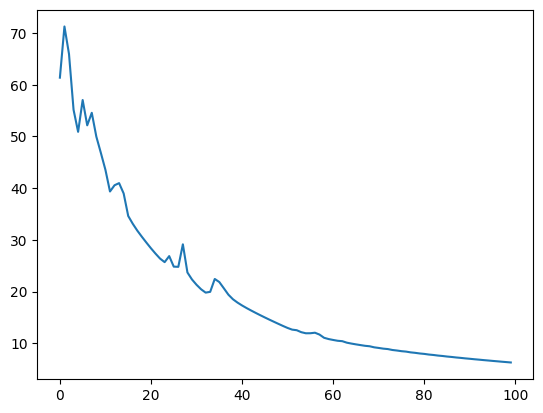

In [9]:
# 损失函数下降情况
import matplotlib.pyplot as plt
plt.plot(train_loss)

In [10]:
import time

# LSTM 背诵歌词
c = cp.zeros(hidden_size)
h = cp.zeros(hidden_size)
for i in range(X.shape[0]):
    
    yt_hat, h = rnn.RNN_cell(cp.expand_dims(X[i], axis = 1), h)
    if list(word_dict.keys())[cp.argmax(yt_hat.squeeze(0), axis = -1).item()] == "<end>":
        break
    print(list(word_dict.keys())[cp.argmax(yt_hat.squeeze(0), axis = -1).item()])
    time.sleep(0.5)

《星辰大海》
歌手：黄霄云
我
向
你
奔赴
而
来
，
你
就是
星辰
大海
。
